In [2]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### For visualising the outputs ###

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

### Load dataset and annotations

In [4]:
data_dir = './Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style'
data_type = 'test'
annotations_file = '{}/annotations/{}.json'.format(data_dir, data_type)
dataset_dir = '{}/images/{}'.format(data_dir, data_type)

# Initialise the COCO api for instance annotations
coco = COCO(annotations_file)

# Load the categories in a variable
category_ids = coco.getCatIds(catNms=['ship'])
categories = coco.loadCats(category_ids)

print(categories)

# Get all images containing the above Category IDs
img_ids = coco.getImgIds(catIds=category_ids)
dataset_size_train = len(img_ids)
print("\nNumber of images containing ships in the %s directory:" % data_type, dataset_size_train)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: './Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/annotations/test.json'

113


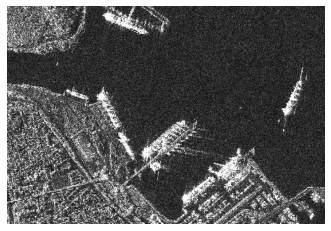

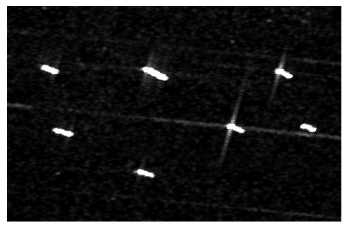

In [77]:
# load and display a random image
# img = coco.loadImgs(img_ids[np.random.randint(0, len(img_ids))])[0] # display random image
# I = io.imread('{}/images/{}/{}'.format(data_dir, data_type, img['file_name']), 0)

# plt.axis('off')
# plt.imshow(I)
# plt.show()
# print(img['file_name'])

list_imgs = coco.loadImgs(img_ids)
# print(img)

inshore_file_index = next((index for (index, d) in enumerate(list_imgs) if d["file_name"] == "000729.jpg"), None)
print(inshore_file_index)
offshore_file_index = next((index for (index, d) in enumerate(list_imgs) if d["file_name"] == "001131.jpg"), None)

inshore_img = coco.loadImgs(img_ids[inshore_file_index])[0]
offshore_img = coco.loadImgs(img_ids[offshore_file_index])[0]

inshore = io.imread('{}/images/{}/{}'.format(data_dir, 'test_inshore', inshore_img['file_name']), 0)
plt.axis('off')
plt.imshow(inshore)
plt.show()

offshore = io.imread('{}/images/{}/{}'.format(data_dir, 'test_offshore', offshore_img['file_name']), 0)
plt.axis('off')
plt.imshow(offshore)
plt.show()


### Generate Instance Segmentation Mask ###

In [1]:
# Load and display instance annotations
# plt.imshow(I)
# plt.axis('off')
# print(img['id'])
# annotation_ids = coco.getAnnIds(imgIds=img['id'], catIds=category_ids, iscrowd=None)
# annotations = coco.loadAnns(annotation_ids)
# coco.showAnns(annotations)
# plt.show()

plt.imshow(inshore)
plt.axis('off')
inshore_annotation_ids = coco.getAnnIds(imgIds=inshore_img['id'], catIds=category_ids, iscrowd=None)
inshore_annotations = coco.loadAnns(inshore_annotation_ids)
coco.showAnns(inshore_annotations)
plt.show()

plt.imshow(offshore)
plt.axis('off')
offshore_annotation_ids = coco.getAnnIds(imgIds=offshore_img['id'], catIds=category_ids, iscrowd=None)
offshore_annotations = coco.loadAnns(offshore_annotation_ids)
coco.showAnns(offshore_annotations)
plt.show()

NameError: name 'plt' is not defined

### Semantic Segmentation Mask ###

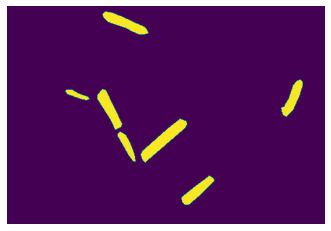

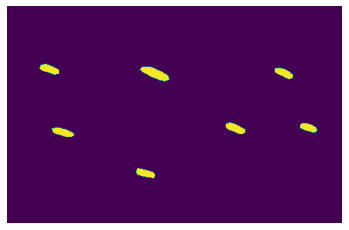

In [79]:
inshore_mask = np.zeros((inshore_img['height'], inshore_img['width']))
# print(inshore_annotations)
# print(len(inshore_annotations))
for i in range(len(inshore_annotations)):
    inshore_mask = np.maximum(coco.annToMask(inshore_annotations[i]), inshore_mask)
plt.axis('off')
plt.imshow(inshore_mask)
plt.show()

offshore_mask = np.zeros((offshore_img['height'], offshore_img['width']))
# print(offshore_annotations)
# print(len(offshore_annotations))
for i in range(len(offshore_annotations)):
    offshore_mask = np.maximum(coco.annToMask(offshore_annotations[i]), offshore_mask)
plt.axis('off')
plt.imshow(offshore_mask)
plt.show()

### Data Exploration - Distribution of Image Sizes ###

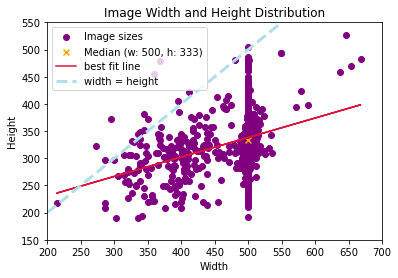

min width: 214, max width: 668
min height: 190, max height: 526
median width: 500, median height: 333
line of best fit: height = 0.358*width + 159.199


In [80]:
root = "Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images"
root_dir = os.listdir(root)

width_set = []
height_set = []

for dir in root_dir:
    path = os.path.join(root, dir)
    if os.path.isdir(path):
        if os.path.basename(dir) == 'test' or os.path.basename(dir) == 'train':
            for img in os.listdir(path):
                # get the image height & width
                image_location = os.path.join(path, img)
                im = Image.open(image_location)
                data = im.size
                width = data[0]
                height = data[1]
                width_set.append(width)
                height_set.append(height)

median_width = int(np.median(width_set))
median_height = int(np.median(height_set))

fig, ax = plt.subplots()

# label plot
plt.title('Image Width and Height Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.axis(xmin=min(width_set) // 50 * 50, xmax=(max(width_set) // 50 * 50) + 50, ymin=min(height_set) // 50 * 50, ymax=(max(height_set) // 50 * 50) + 50)

# scale axis
plt.xticks(np.arange(min(width_set) // 50 * 50, (max(width_set) // 50 * 50) + 51, 50))
plt.yticks(np.arange(min(height_set) // 50 * 50, (max(height_set) // 50 * 50) + 51, 50))

# scatter plot of image sizes
ax.scatter(width_set, height_set, color='purple', label='Image sizes')

# median width and height of image sizes
ax.scatter(median_width, median_height, marker='x', color='orange', label='Median (w: {}, h: {})'.format(median_width, median_height))

# line of best fit
z = np.polyfit(width_set, height_set, 1)
p = np.poly1d(z)
ax.plot(width_set, p(width_set), color='#DC143C', label='best fit line')

# y=x
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='#B0E0E6', lw=3, scalex=False, scaley=False, label='width = height')

# key
ax.legend(loc='upper left')
plt.show()

print('min width: {}, max width: {}'.format(min(width_set), max(width_set)))
print('min height: {}, max height: {}'.format(min(height_set), max(height_set)))

print('median width: {}, median height: {}'.format(median_width, median_height))

print("line of best fit: height = %.3f*width + %.3f" % (z[0], z[1]))

### Image Standardisation ###
---
**Without having a fixed input shape, we cannot define the architecture of the model.
It is therefore necessary to convert all the images to same size.
Now that we have found a suitable middle ground, we can resize all our images to match
the median width and height of the dataset.**

In [81]:
# convert all images to median size whilst retaining folder structure
for dir in root_dir:
    path = os.path.join(root, dir)
    if os.path.isdir(path):
        save_path = 'cleaned/' + dir
        image_dir = os.listdir(path)
        print(path)
        for img in image_dir:
            original_image = cv2.imread(os.path.join(path, img))
            new_img = cv2.resize(original_image, (median_width, median_height) , interpolation=cv2.INTER_NEAREST)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path + '/' + img, new_img)
        print(save_path)

Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images/test
cleaned/test
Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images/train
cleaned/train
Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images/test_inshore
cleaned/test_inshore
Official-SSDD-OPEN/BBox_RBox_PSeg_SSDD/coco_style/images/test_offshore
cleaned/test_offshore


*Standardised images will appear in their respective sub-folders within the cleaned directory.*

### Data Augmentation ###

In [82]:
# Create a data generator
def filterDataset():
    # Initialise the COCO api for instance annotations
    annotations_file = '{}/annotations/{}.json'.format(data_dir, data_type)
    coco = COCO(annotations_file)

    # images = []
    # if classes!=None:
    #     # iterate for each individual class in the list
    #     for className in classes:
    #         # get all images containing given categories
    #         catIds = coco.getCatIds(catNms=className)
    #         imgIds = coco.getImgIds(catIds=catIds)
    #         images += coco.loadImgs(imgIds)
    #
    # else:

    # we only have a single type of class so this has been simplified
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images
    # unique_images = []
    # for i in range(len(images)):
    #     if images[i] not in unique_images:
    #         unique_images.append(images[i])

    return images, coco

images, coco = filterDataset()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Generate the Images and Masks Batches ###

In [83]:
# Auxiliary functions
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalise an image
    train_img = cv2.imread(img_folder + '/' + imageObj['file_name'], 0) # / 255.0


    # grey_img = cv2.imread(img_folder + '/' + imageObj['file_name'], 0)
    # plt.axis('off')
    # plt.imshow(grey_img)
    # plt.show()

    # Resize
    # print(train_img.shape)
    # print(grey_img.shape)
    train_img = cv2.resize(train_img, input_image_size)
    train_img = train_img[:, :, np.newaxis]
    # if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
    return train_img
    # else: # To handle a black and white image, increase dimensions to 3
    #     stacked_img = np.stack((train_img,) * 3, axis=-1)
    #     return stacked_img

def getSegmentationMask(imageObj, coco, category_ids, input_image_size):
    annotation_ids = coco.getAnnIds(imgIds=imageObj['id'], catIds=category_ids, iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)
    # Numpy will read the image by order Height x Width x Depth
    # swap the order of width and height to maintain the image shape
    train_mask = np.zeros((input_image_size[1], input_image_size[0]))
    for a in range(len(annotations)):
        new_mask = cv2.resize(coco.annToMask(annotations[a]), input_image_size)

        # Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    # Numpy will read the image by order Height x Width x Depth
    # swap the order of width and height to maintain the image shape
    train_mask = train_mask.reshape(input_image_size[1], input_image_size[0], 1)
    return train_mask

In [84]:
# Generator object to yield images and masks in batches
def dataGeneratorCoco(images, input_image_size, batch_size, folder='cleaned', mode='train'):
    img_folder = '{}/{}'.format(folder, mode)

    c = 0
    while(True):
        # Numpy will read the image by order Height x Width x Depth
        # swap the order of width and height to maintain the image shape
        img = np.zeros((batch_size, input_image_size[1], input_image_size[0], 1)).astype('float')
        mask = np.zeros((batch_size, input_image_size[1], input_image_size[0], 1)).astype('float')

        for i in range(c, c + batch_size): # initially from 0 to batch_size, when c = 0
            imageObj = images[i]

            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)

            ### Create Mask ###
            train_mask = getSegmentationMask(imageObj, coco, category_ids, input_image_size)

            # Add to respective batch sized arrays
            img[i - c] = train_img
            mask[i - c] = train_mask

        c += batch_size
        if(c + batch_size >= len(images)):
            c = 0
            random.shuffle(images)
        yield img, mask

batch_size = 400
input_image_size = (median_width, median_height)

val_gen = dataGeneratorCoco(images, input_image_size, batch_size)

### Visualise Generator ###

In [85]:
def visualiseGenerator(gen):
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=-0.45)
        for j in range(4):
            # Read file names from end of array
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

visualiseGenerator(val_gen)

[ WARN:0@3002.073] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('cleaned/train/000001.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### Data Augmentation ###

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialise the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)

    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialise the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)

    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds synchronised otherwise the augmentation of the images
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(img,
                             batch_size=img.shape[0],
                             seed=seed,
                             shuffle=True)
        g_y = image_gen.flow(mask,
                             batch_size=mask.shape[0],
                             seed=seed,
                             shuffle=True)

        img_aug = next(g_x)
        mask_aug = next(g_y)

        yield img_aug, mask_aug

augGeneratorArgs = dict(featurewise_center=False,
                        samplewise_center=False,
                        rotation_range=5,
                        width_shift_range=0.01,
                        height_shift_range=0.01,
                        brightness_range=(0.8,1.2),
                        shear_range=0.01,
                        zoom_range=[1, 1.25],
                        horizontal_flip=True,
                        vertical_flip=False,
                        fill_mode='reflect',
                        data_format='channels_last')

# Call the function with the arguments
aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

visualiseGenerator(aug_gen)

NameError: name 'val_gen' is not defined

In [ ]:
# -> Create filtered train dataset (using filterDataset())
# -> Create filtered val dataset (using filterDataset())
# -> Create train generator (using dataGeneratorCoco())
# -> Create val generator (using dataGeneratorCoco())
train_gen = dataGeneratorCoco(images, input_image_size, batch_size)
train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

val_gen = dataGeneratorCoco(images, input_image_size, batch_size)
val_gen_aug = augmentationsGenerator(val_gen, augGeneratorArgs)

# Parameters
n_epochs = 4
steps_per_epoch = len(images) // batch_size
# validation_steps = dataset_size_val // batch_size

# Compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(500, 300, 1)), # B&W images
    tf.keras.layers.Rescaling(1. / 255, input_shape=(500, 300, 1)), # normalize Images into range 0 to 1.
    # tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    # tf.keras.layers.MaxPooling2D(pool_size=(6, 6)),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(units=80, activation="relu"),
    tf.keras.layers.Conv2D(1, 1, activation="softmax", padding="same")
    # tf.keras.layers.Dense(units=1, activation="softmax")
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Start the training process
history = model.fit(train_gen,
                    epochs=n_epochs,
                    verbose=1)

# model.summary()

# print(x_train.shape, y_train.shape)
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000, reshuffle_each_iteration=True).batch(32)

print(history.history.keys())

# plotting losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

NameError: name 'dataGeneratorCoco' is not defined

In [ ]:
from mrcnn.config import Config

class SimpleConfig(Config):
	NAME = "coco_inference"

	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	NUM_CLASSES = 2


class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

# config = SimpleConfig()
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
import mrcnn.model

model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

Instructions for updating:
Use fn_output_signature instead


In [ ]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [ ]:
'''loading pretrained coco dataset and excluding the last layer'''
model = modellib.MaskRCNN(mode='training', config=config, model_dir=outputPath)
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

### UNet Model ###

In [ ]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
#
# # Use the activations of these layers
# layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
#
# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
#
# down_stack.trainable = False

In [ ]:
# # The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.
# up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#     pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#     pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
# ]

In [ ]:
# def unet_model():
#     inputs = tf.keras.layers.Input(shape=[128, 128, 3])
#
#     # Downsampling through the model
#     skips = down_stack(inputs)
#     x = skips[-1]
#     skips = reversed(skips[:-1])
#
#     # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         concat = tf.keras.layers.Concatenate()
#         x = concat([x, skip])
#
#     # This is the last layer of the model
#     last = tf.keras.layers.Conv2DTranspose(
#       filters=1, kernel_size=3, strides=2,
#       padding='same')  #64x64 -> 128x128
#     # Note that the number of filters on the last layer is set to the number of output_channels of which we only have one.
#     x = last(x)
#
#     return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# # Now, all that is left to do is to compile and train the model.
#
# # Since this is a single class classification problem, use the tf.keras.losses.BinaryCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vectors of scores for each pixel of the class.
#
# # When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.
#
# model = unet_model()
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# # Have a quick look at the resulting model architecture
# tf.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [ ]:
# # Try out the model to check what it predicts before training
#
# def create_mask(pred_mask):
#   pred_mask = tf.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]
#
# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset.take(num):
#       pred_mask = model.predict(image)
#       display([image[0], mask[0], create_mask(pred_mask)])
#   else:
#     display([sample_image, sample_mask,
#              create_mask(model.predict(sample_image[tf.newaxis, ...]))])
#
# show_predictions()